In [1]:
#import packages
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import root_mean_squared_error
import re

#hyperparameters
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 30 

#seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# Sequence creation function
def create_sequences_from_combined_array(all_scaled_data, seq_len, list_of_target_indices_in_data):
    Xs, ys = [], []
    all_scaled_data_np = np.array(all_scaled_data)
    if all_scaled_data_np.ndim == 1:
        all_scaled_data_np = all_scaled_data_np.reshape(-1,1)
    for i in range(len(all_scaled_data_np) - seq_len):
        Xs.append(all_scaled_data_np[i:(i + seq_len), :]) 
        ys.append(all_scaled_data_np[i + seq_len, list_of_target_indices_in_data])
    return np.array(Xs), np.array(ys)

In [2]:
# --- Centralized Data Loading & Preprocessing for NASDAQ.ipynb ---
df_nd = pd.read_csv("NASDAQ-100 (NDX) Historical Data 5Y.csv")

# Initial column cleanup and type conversion
df_nd['Date'] = pd.to_datetime(df_nd['Date'])
df_nd.rename(columns={
    'Close/Last': 'CloseLast'
}, inplace=True) # NASDAQ CSV has fewer columns like Vol. or Change %

df_nd.set_index('Date', inplace=True)
df_nd.sort_index(inplace=True)

# Define features and target
# NASDAQ CSV typically contains: Date, Close/Last, Open, High, Low
# !!! IMPORTANT: Review and adjust 'features_for_scaling' and 'target_col_name' to your actual needs! !!!
target_col_name = 'CloseLast' 
features_to_include = ['Open', 'High', 'Low', 'CloseLast'] # No Vol. or Change % in NASDAQ CSV

features_present_in_df = [f for f in features_to_include if f in df_nd.columns]

features_for_scaling = list(features_present_in_df)
if target_col_name not in features_for_scaling and target_col_name in df_nd.columns:
    features_for_scaling.append(target_col_name)
features_for_scaling = list(dict.fromkeys(features_for_scaling))

if target_col_name not in features_for_scaling:
    raise ValueError(f"Target column '{target_col_name}' must be in 'features_for_scaling'. Available: {df_nd.columns.tolist()}")

target_idx_in_scaled_data = [features_for_scaling.index(target_col_name)]

df_processed = df_nd[features_for_scaling].copy()
df_processed.dropna(inplace=True) # Handle any NaNs if present, though less likely here

data_to_scale = df_processed.values
dates_processed = df_processed.index

# --- Data Splitting (by year) ---
train_start_year, train_end_year = 2019, 2023
test_year = 2024
final_val_year = 2025

train_idx_bool = (dates_processed.year >= train_start_year) & (dates_processed.year <= train_end_year)
test_idx_bool = dates_processed.year == test_year
val2025_idx_bool = dates_processed.year == final_val_year
trainval_idx_bool = (dates_processed.year >= train_start_year) & (dates_processed.year <= test_year)

# --- Scaling (Fit ONLY on initial training data) ---
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(data_to_scale[train_idx_bool])

scaled_test_data = scaler.transform(data_to_scale[test_idx_bool])
scaled_val2025_data = scaler.transform(data_to_scale[val2025_idx_bool])
scaled_trainval_data = scaler.transform(data_to_scale[trainval_idx_bool])

# --- Sequence Creation for all datasets ---
X_train, y_train = create_sequences_from_combined_array(scaled_train_data, SEQ_LEN, target_idx_in_scaled_data)
X_test, y_test = create_sequences_from_combined_array(scaled_test_data, SEQ_LEN, target_idx_in_scaled_data)
X_val2025, y_val2025 = create_sequences_from_combined_array(scaled_val2025_data, SEQ_LEN, target_idx_in_scaled_data)
X_trainval, y_trainval = create_sequences_from_combined_array(scaled_trainval_data, SEQ_LEN, target_idx_in_scaled_data)

# --- Corresponding Dates for Sequences ---
dates_train_seq = dates_processed[train_idx_bool][SEQ_LEN:]
dates_test_seq = dates_processed[test_idx_bool][SEQ_LEN:]
dates_val2025_seq = dates_processed[val2025_idx_bool][SEQ_LEN:]
dates_trainval_seq = dates_processed[trainval_idx_bool][SEQ_LEN:]

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Features for scaling: {features_for_scaling}")
print(f"Target index: {target_idx_in_scaled_data}")

Shape of X_train: (888, 20, 4), y_train: (888, 1)
Features for scaling: ['Open', 'High', 'Low', 'CloseLast']
Target index: [3]


In [3]:
# --- Model Definitions (Copied from DowJones_modified, output_size=1 is default) ---
class StockGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

--- Initial Training for NASDAQ GRU ---
Initial NASDAQ GRU: Epoch [10/30], Loss: 0.0010
Initial NASDAQ GRU: Epoch [20/30], Loss: 0.0007
Initial NASDAQ GRU: Epoch [30/30], Loss: 0.0007
Initial NASDAQ GRU - Test RMSE (2024): 475.97
--- Initial Training for NASDAQ LSTM ---
Initial NASDAQ LSTM: Epoch [10/30], Loss: 0.0022
Initial NASDAQ LSTM: Epoch [20/30], Loss: 0.0016
Initial NASDAQ LSTM: Epoch [30/30], Loss: 0.0015
Initial NASDAQ LSTM - Test RMSE (2024): 868.70
--- Initial Training for NASDAQ RNN ---
Initial NASDAQ RNN: Epoch [10/30], Loss: 0.0009
Initial NASDAQ RNN: Epoch [20/30], Loss: 0.0006
Initial NASDAQ RNN: Epoch [30/30], Loss: 0.0010
Initial NASDAQ RNN - Test RMSE (2024): 733.81


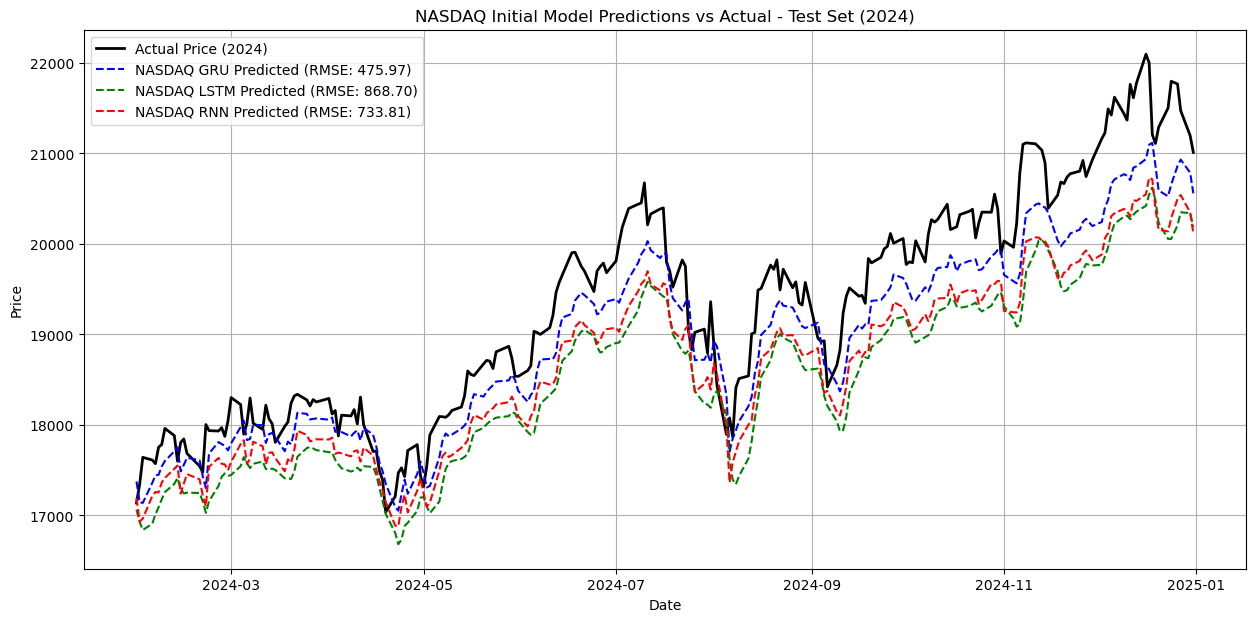

In [4]:
# --- Initial Training and Evaluation (Train: 2019-2023, Test: 2024) for all models ---
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset_init = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_init = DataLoader(train_dataset_init, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_init = TensorDataset(X_test_tensor, y_test_tensor)
test_loader_init = DataLoader(test_dataset_init, batch_size=BATCH_SIZE, shuffle=False)

input_size_init = X_train.shape[2]
initial_models_nd = {}
initial_results_nd = {}

model_classes_nd = {"GRU": StockGRU, "LSTM": StockLSTM, "RNN": StockRNN}
plot_colors_init_nd = {"GRU": "blue", "LSTM": "green", "RNN": "red"}

for model_name, ModelClass in model_classes_nd.items():
    print(f"--- Initial Training for NASDAQ {model_name} ---")
    H_init, L_init, LR_init = 64, 2, 0.001
    
    model = ModelClass(input_size_init, H_init, L_init, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_init)
    
    for epoch in range(N_EPOCHS):
        model.train()
        for X_batch, y_batch in train_loader_init:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Initial NASDAQ {model_name}: Epoch [{epoch+1}/{N_EPOCHS}], Loss: {loss.item():.4f}')
    initial_models_nd[model_name] = model
    
    model.eval()
    preds_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader_init:
            output = model(X_batch)
            preds_scaled.extend(output.numpy())
    preds_scaled = np.array(preds_scaled)
    
    dummy_preds = np.zeros((len(preds_scaled), len(features_for_scaling)))
    dummy_preds[:, target_idx_in_scaled_data[0]] = preds_scaled.flatten()
    preds_inversed = scaler.inverse_transform(dummy_preds)[:, target_idx_in_scaled_data[0]]
    
    dummy_actuals = np.zeros((len(y_test), len(features_for_scaling)))
    dummy_actuals[:, target_idx_in_scaled_data[0]] = y_test.flatten()
    actuals_inversed = scaler.inverse_transform(dummy_actuals)[:, target_idx_in_scaled_data[0]]
    
    rmse = root_mean_squared_error(actuals_inversed, preds_inversed)
    print(f'Initial NASDAQ {model_name} - Test RMSE (2024): {rmse:.2f}')
    initial_results_nd[model_name] = {'rmse': rmse, 'preds_inversed': preds_inversed, 'actuals_inversed': actuals_inversed}

plt.figure(figsize=(15, 7))
plt.plot(dates_test_seq, initial_results_nd["GRU"]['actuals_inversed'], label='Actual Price (2024)', color='black', linewidth=2)
for model_name in initial_models_nd.keys():
    plt.plot(dates_test_seq, initial_results_nd[model_name]['preds_inversed'], 
             label=f'NASDAQ {model_name} Predicted (RMSE: {initial_results_nd[model_name]["rmse"]:.2f})', 
             color=plot_colors_init_nd[model_name], linestyle='--')
plt.title(f'NASDAQ Initial Model Predictions vs Actual - Test Set (2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparameter Tuning & Final Validation (Train: 2019-2024, Validate: 2025)

In [5]:
X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.float32)
X_final_val_tensor = torch.tensor(X_val2025, dtype=torch.float32)
y_final_val_tensor = torch.tensor(y_val2025, dtype=torch.float32)

trainval_dataset_nd = TensorDataset(X_trainval_tensor, y_trainval_tensor)
trainval_loader_nd = DataLoader(trainval_dataset_nd, batch_size=BATCH_SIZE, shuffle=True)

final_val_dataset_nd = TensorDataset(X_final_val_tensor, y_final_val_tensor)
final_val_loader_nd = DataLoader(final_val_dataset_nd, batch_size=BATCH_SIZE, shuffle=False)

print(f"Shape of X_trainval_tensor for NASDAQ: {X_trainval_tensor.shape}")

Shape of X_trainval_tensor for NASDAQ: torch.Size([1140, 20, 4])


In [6]:
param_grid_nd = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}
all_params_tuning_nd = [dict(zip(param_grid_nd.keys(), v)) for v in product(*param_grid_nd.values())]

results_tuning_nd = {}
best_configs_tuning_nd = {}
best_model_states_tuning_nd = {}

input_size_tuning_nd = X_trainval.shape[2]

for model_name, ModelClass in model_classes_nd.items():
    print(f"\n--- Hyperparameter Tuning for NASDAQ {model_name} ---")
    best_val_rmse_model_nd = float('inf')
    best_params_model_nd = None
    best_model_state_model_nd = None
    model_tuning_log_nd = []

    for params in all_params_tuning_nd:
        H, L, LR = params['hidden_size'], params['num_layers'], params['learning_rate']
        
        current_model_tuning = ModelClass(input_size_tuning_nd, H, L, output_size=1)
        criterion_tuning = nn.MSELoss()
        optimizer_tuning = torch.optim.Adam(current_model_tuning.parameters(), lr=LR)
        
        for epoch in range(N_EPOCHS // 2):
            current_model_tuning.train()
            for X_batch, y_batch in trainval_loader_nd:
                optimizer_tuning.zero_grad()
                output = current_model_tuning(X_batch)
                loss = criterion_tuning(output, y_batch)
                loss.backward()
                optimizer_tuning.step()
        
        current_model_tuning.eval()
        current_val_preds_scaled = []
        with torch.no_grad():
            for X_batch, y_batch in final_val_loader_nd:
                output = current_model_tuning(X_batch)
                current_val_preds_scaled.extend(output.numpy())
        current_val_preds_scaled = np.array(current_val_preds_scaled)
        
        dummy_preds_val = np.zeros((len(current_val_preds_scaled), len(features_for_scaling)))
        dummy_preds_val[:, target_idx_in_scaled_data[0]] = current_val_preds_scaled.flatten()
        current_val_preds_inversed = scaler.inverse_transform(dummy_preds_val)[:, target_idx_in_scaled_data[0]]
        
        dummy_actuals_val = np.zeros((len(y_val2025), len(features_for_scaling)))
        dummy_actuals_val[:, target_idx_in_scaled_data[0]] = y_val2025.flatten()
        y_val2025_inversed = scaler.inverse_transform(dummy_actuals_val)[:, target_idx_in_scaled_data[0]]
        
        current_rmse_val = root_mean_squared_error(y_val2025_inversed, current_val_preds_inversed)
        model_tuning_log_nd.append({'params': params, 'val_rmse': current_rmse_val})
        
        if current_rmse_val < best_val_rmse_model_nd:
            best_val_rmse_model_nd = current_rmse_val
            best_params_model_nd = params
            best_model_state_model_nd = current_model_tuning.state_dict()
            
    results_tuning_nd[model_name] = {
        'best_val_rmse_2025': best_val_rmse_model_nd,
        'best_params': best_params_model_nd,
        'log': model_tuning_log_nd,
        'actual_2025': y_val2025_inversed
    }
    best_configs_tuning_nd[model_name] = best_params_model_nd
    best_model_states_tuning_nd[model_name] = best_model_state_model_nd
    print(f"Best Validation RMSE for NASDAQ {model_name} (2025): {best_val_rmse_model_nd:.2f} with params: {best_params_model_nd}")


--- Hyperparameter Tuning for NASDAQ GRU ---
Best Validation RMSE for NASDAQ GRU (2025): 418.72 with params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001}

--- Hyperparameter Tuning for NASDAQ LSTM ---
Best Validation RMSE for NASDAQ LSTM (2025): 582.31 with params: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.001}

--- Hyperparameter Tuning for NASDAQ RNN ---
Best Validation RMSE for NASDAQ RNN (2025): 425.16 with params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001}


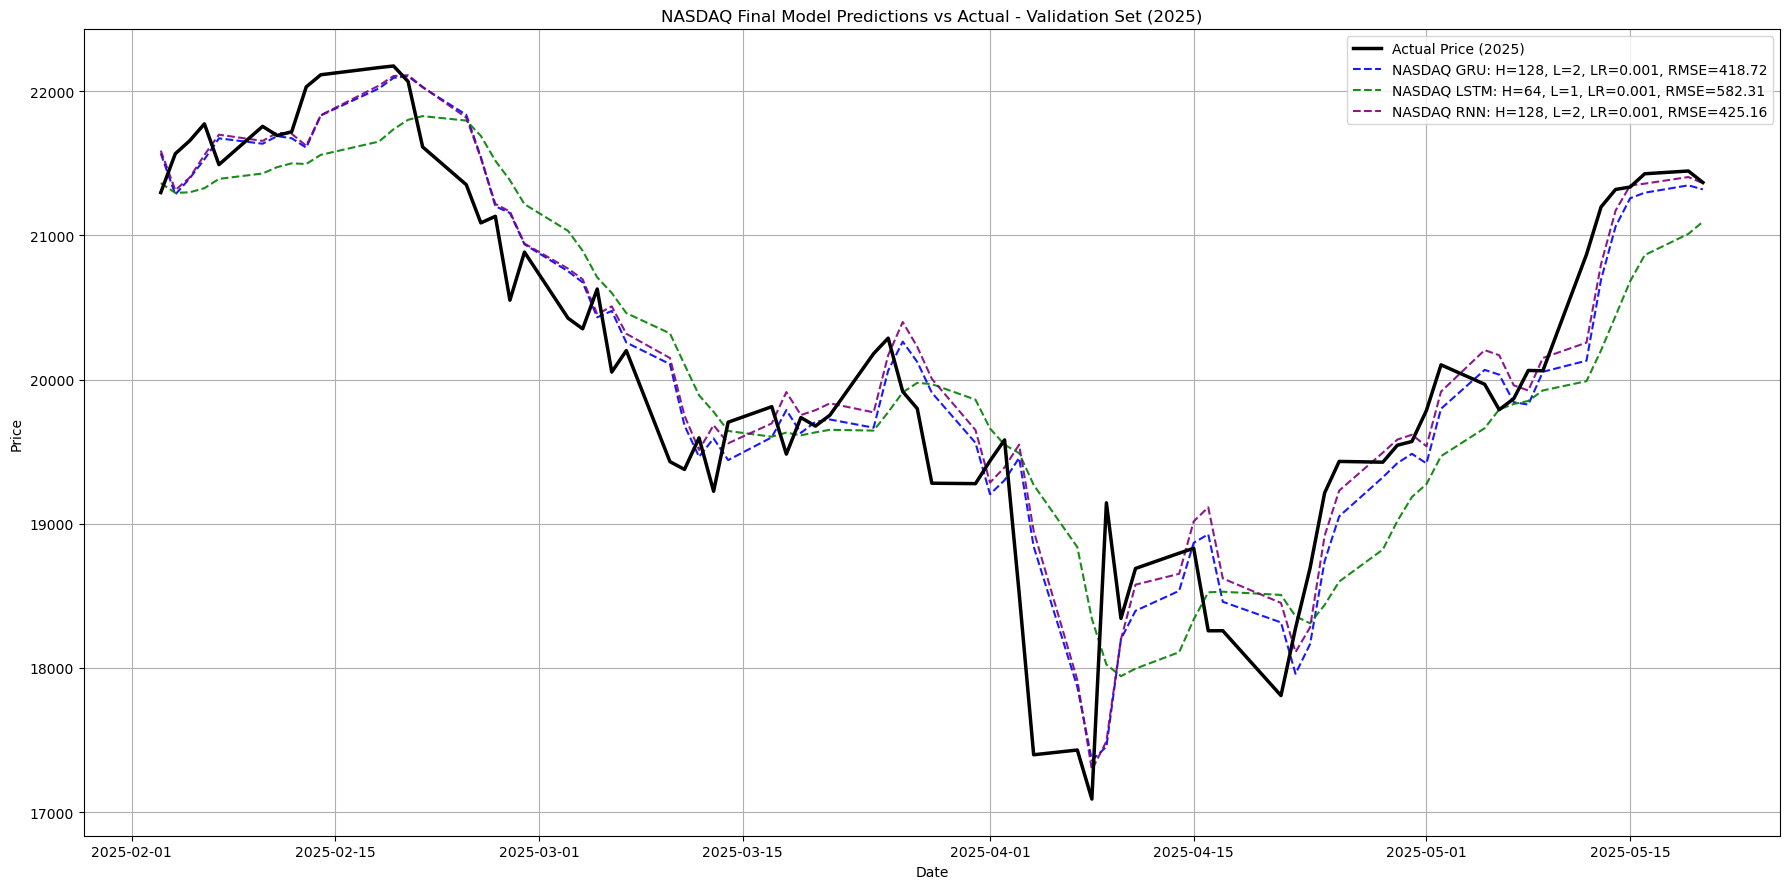

In [7]:
# --- Final Evaluation and Plotting with Best Tuned Models on 2025 Validation Set ---
plt.figure(figsize=(18, 9))

actual_2025_data_for_plot_nd = results_tuning_nd.get("GRU", {}).get("actual_2025")
if actual_2025_data_for_plot_nd is not None:
    plt.plot(dates_val2025_seq, actual_2025_data_for_plot_nd, label='Actual Price (2025)', color='black', linewidth=2.5, zorder=5)

final_plot_colors_nd = {"GRU": "blue", "LSTM": "green", "RNN": "purple"} # Changed RNN to purple

for model_name, ModelClass in model_classes_nd.items():
    if model_name not in best_configs_tuning_nd or best_configs_tuning_nd[model_name] is None:
        print(f"No best configuration found for NASDAQ {model_name}. Skipping final plot.")
        continue
        
    best_params = best_configs_tuning_nd[model_name]
    best_model_final = ModelClass(input_size_tuning_nd, 
                                  best_params['hidden_size'], 
                                  best_params['num_layers'], 
                                  output_size=1)
    if best_model_states_tuning_nd[model_name] is not None:
        best_model_final.load_state_dict(best_model_states_tuning_nd[model_name])
    else:
        print(f"No model state found for NASDAQ {model_name}. Skipping final plot.")
        continue
    best_model_final.eval()
    
    final_preds_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in final_val_loader_nd:
            output = best_model_final(X_batch)
            final_preds_scaled.extend(output.numpy())
    final_preds_scaled = np.array(final_preds_scaled)
    
    dummy_final_preds = np.zeros((len(final_preds_scaled), len(features_for_scaling)))
    dummy_final_preds[:, target_idx_in_scaled_data[0]] = final_preds_scaled.flatten()
    final_preds_inversed = scaler.inverse_transform(dummy_final_preds)[:, target_idx_in_scaled_data[0]]
    
    results_tuning_nd[model_name]['pred_2025_final_best'] = final_preds_inversed
    final_rmse = results_tuning_nd[model_name]['best_val_rmse_2025']
    
    legend_label = f"NASDAQ {model_name}: H={best_params['hidden_size']}, L={best_params['num_layers']}, LR={best_params['learning_rate']}, RMSE={final_rmse:.2f}"
    plt.plot(dates_val2025_seq, final_preds_inversed, 
             label=legend_label, 
             color=final_plot_colors_nd[model_name], 
             linestyle='--', alpha=0.9)

plt.title(f'NASDAQ Final Model Predictions vs Actual - Validation Set (2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()